## **Brain Tumor Detection Using CNN**

In [2]:
from google.colab import drive # Connecting Google Colab with Google Drive
drive.mount('/content/gdrive') #drive.mount is used to mount data which is present in drive

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Dataset/brain_tumor.zip

In [4]:
import os

In [5]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root = "/content/brain tumor"

dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 1500, 'yes': 1500}

**Plotting images from dataset.**

In [6]:
import matplotlib.pyplot as plt

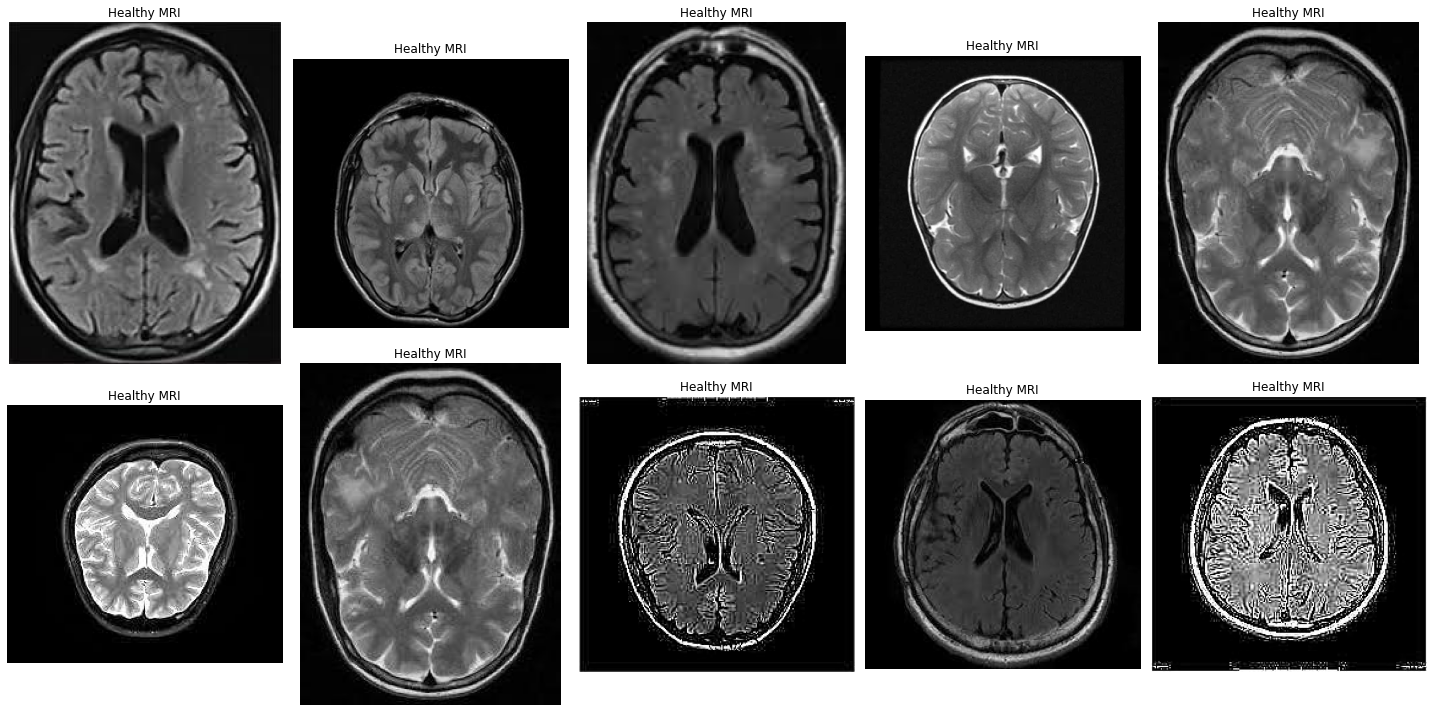

In [7]:
healthy = os.listdir("/content/brain tumor/no")
healthy_dir = "/content/brain tumor/no"
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = plt.imread(os.path.join(healthy_dir, healthy[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Healthy MRI") 

plt.tight_layout()

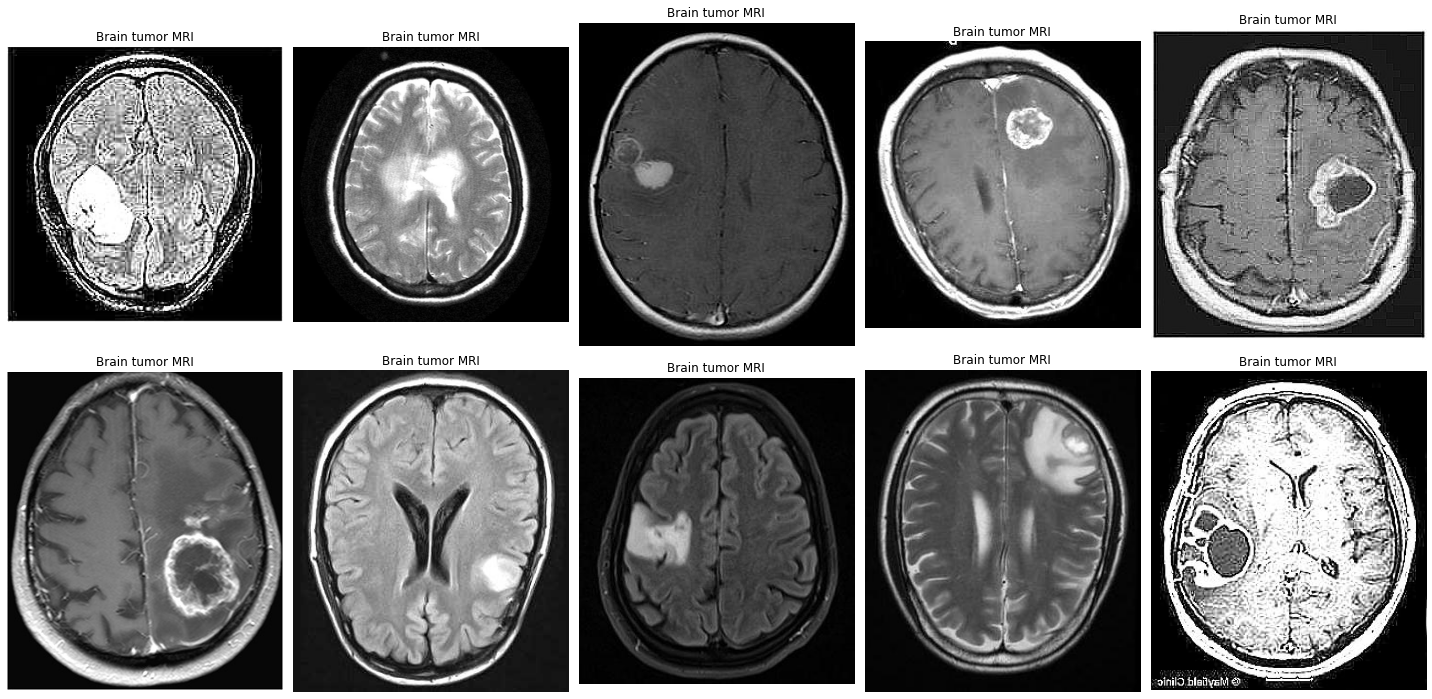

In [8]:
brain_tumor = os.listdir("/content/brain tumor/yes")
brain_tumor_dir = "/content/brain tumor/yes"
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = plt.imread(os.path.join(brain_tumor_dir, brain_tumor[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Brain tumor MRI") 

plt.tight_layout()

**Part 1: Train-Test-Validation Split**

In [9]:
import math
import shutil

In [10]:
import numpy as np

In [11]:
#Define a function that creates new folders for the training, testing and validation and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [12]:
#Create the training set
create_folders('train', 0.7)

In [13]:
#Create the testing set
create_folders('test', 0.15)

In [14]:
#Create the validating set
create_folders('val', 0.15)

In [15]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [16]:
#Count images in the training set
count_img('train')

{'no': 1050, 'yes': 1050}

In [17]:
#Count images in the test set
count_img('test')

{'no': 225, 'yes': 225}

In [18]:
#Count images in the validation set
count_img('val')

{'no': 225, 'yes': 225}

**Part 2: Image Preprocessing**

In [26]:
# Preprocessing the Training dataset

# Feature Scaling
from keras.preprocessing.image import ImageDataGenerator
def preprocessingImages1(path):
  image_generator = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
  )
  # This generator will read pictures found in train foler, and generate batches of preprocessed image data
  image = image_generator.flow_from_directory(directory=path, 
                                              shuffle=True,
                                              target_size = (180,180), 
                                              batch_size=16, 
                                              class_mode='binary')

  return image

In [27]:
path ="/content/train"
train = preprocessingImages1(path)

Found 2100 images belonging to 2 classes.


In [22]:
# Preprocessing the Validation dataset

# Feature Scaling
def preprocessingImages2(path):
  image_generator = ImageDataGenerator(
    rescale=1/255,
)
  
# This generator will read pictures found in validation foler, and generate batches of augmented image data
  image = image_generator.flow_from_directory(directory=path, 
                                              shuffle=False,
                                              target_size = (180,180), 
                                              batch_size=1, 
                                              class_mode='binary')

  return image

In [23]:
path ="/content/val"
validation = preprocessingImages2(path)

Found 450 images belonging to 2 classes.


**Part 3: Building the CNN**

In [28]:
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAvgPool2D
from keras.preprocessing.image import load_img, img_to_array

In [29]:
#CNN Model

model = Sequential() 
model.add(Conv2D(filters=24, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=216, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten()) 

model.add(Dense(units=128, activation='relu')) 
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 24)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 64)        13888     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 44, 44, 64)        0

**Part 4: Model Training**

In [31]:
# Compiling the CNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Early Stopping 
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=12, verbose=1, mode='auto')

#Model Checkpoint 
mc = ModelCheckpoint(monitor='val_accuracy', filepath="./bestmodel.h5",  verbose=1, save_best_only=True, mode='auto')

cd=[es,mc]

In [33]:
# Training the CNN on the Training set and evaluating it on the Test set
his = model.fit_generator(
    generator=train, 
    epochs=100,
    validation_data=validation, 
    callbacks=cd,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.5024
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./bestmodel.h5
132/132 [==============================] - 34s 166ms/step - loss: 0.6967 - accuracy: 0.5024 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.5814
Epoch 2: val_accuracy improved from 0.50000 to 0.71556, saving model to ./bestmodel.h5
132/132 [==============================] - 21s 159ms/step - loss: 0.6672 - accuracy: 0.5814 - val_loss: 0.6384 - val_accuracy: 0.7156
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.6024 - accuracy: 0.6767
Epoch 3: val_accuracy did not improve from 0.71556
132/132 [==============================] - 21s 159ms/step - loss: 0.6024 - accuracy: 0.6767 - val_loss: 0.5898 - val_accuracy: 0.6889
Epoch 4/100
132/132 [==============================] - ETA: 0s - loss: 0.5717 - accur

**Part 5: Graphical Interpretation**

Text(0.5, 1.0, 'Loss Evolution')

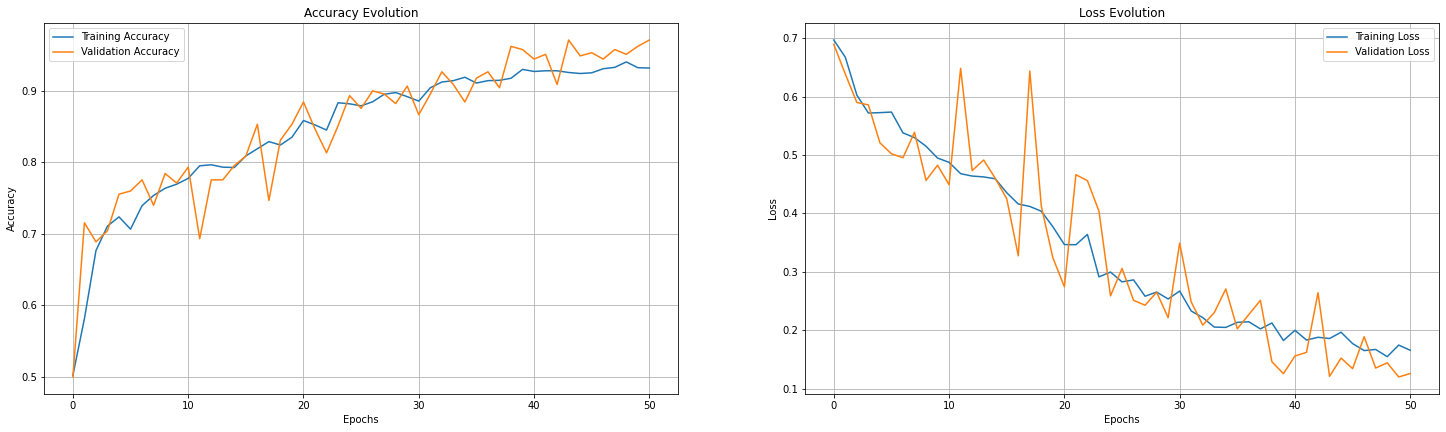

In [34]:
plt.figure(figsize=(25, 15))

#Model Accuracy
plt.subplot(2,2,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( his.history["accuracy"], label = "Training Accuracy")
plt.plot( his.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.title('Accuracy Evolution')

#Model Loss
plt.subplot(2, 2, 2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(his.history['loss'], label='Training Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.grid(True)
plt.legend()
plt.title('Loss Evolution')

In [35]:
t = model.evaluate_generator(train)
v = model.evaluate_generator(validation)
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(t[1]*100,t[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(v[1]*100,v[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Training Accuracy  : 96.52%     Training loss  : 0.105923
Validation Accuracy: 97.11%     Validation loss: 0.125594


**Part 6: Making Prediction**

In [36]:
import cv2

In [40]:
# Prediction 1 : Actual - Brain Tumor MRI

img= cv2.imread('/content/test/yes/y1094.jpg')
copy = img
img = cv2.resize(img,(180,180))
img = img/255.0
img = img.reshape(1,180,180,3)
model.predict(img)

array([[0.9999906]], dtype=float32)

Prediction: Brain Tumor Detected.


Text(0.5, 1.0, 'Prediction: Brain Tumor Detected.')

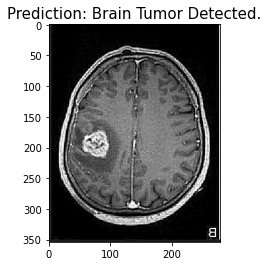

In [41]:
prediction = model.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Brain Tumor Detected."
else:
  prediction = "Healthy MRI"
print("Prediction: "+prediction)
plt.imshow(copy)

plt.title("Prediction: "+prediction, fontsize=15)

In [42]:
# Prediction 2 : Actual - Healthy MRI

img= cv2.imread('/content/test/no/no1080.jpg')
copy = img
img = cv2.resize(img,(180,180))
img = img/255.0
img = img.reshape(1,180,180,3)
model.predict(img)

array([[0.11030249]], dtype=float32)

Prediction: Healthy MRI


Text(0.5, 1.0, 'Prediction: Healthy MRI')

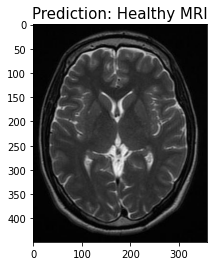

In [43]:
prediction = model.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Brain Tumor Detected."
else:
  prediction = "Healthy MRI"
print("Prediction: "+prediction)
plt.imshow(copy)

plt.title("Prediction: "+prediction, fontsize=15)